# Cluster Characterization

This notebook trains an Artificial Neural Network for cluster characterization.

## Initial settings

In [1]:
from cdalvaro.catalogues import OpenClust
from cdalvaro.data_base import DB
import cdalvaro.graphics
from cdalvaro.logging import Logger
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

In [2]:
logger = Logger.instance()
logger.setLevel(logging.ERROR)

db = DB.instance(host='gaia.cdalvaro.io', port=15432)

cdalvaro.graphics.set_color_palette()
cdalvaro_plot = cdalvaro.graphics.Plot(save_figs=False, figs_path="../../figures")

In [3]:
clusters = OpenClust.catalogue()
columns = [
    "ra", "ra_error", "dec", "dec_error", "pmra", "pmra_error",
    "pmdec", "pmdec_error", "parallax", "parallax_error",
    "phot_g_mean_mag", "bp_rp", "radial_velocity", "radial_velocity_error"
]

dec_columns = list(filter(lambda x: not re.search(r'_error', x), columns))

In [4]:
cluster = clusters["Melotte 22"]
cluster_stars = db.get_stars(region=cluster, columns=columns, filter_null_columns=False)
cluster_stars.isnull().sum()

ra                           0
ra_error                     0
dec                          0
dec_error                    0
pmra                      8547
pmra_error                8547
pmdec                     8547
pmdec_error               8547
parallax                  8547
parallax_error            8547
phot_g_mean_mag              0
bp_rp                     4909
radial_velocity          60537
radial_velocity_error    60537
dtype: int64

# Deep Embedded Clustering (DEC)

## Links

- https://towardsdatascience.com/deep-clustering-for-financial-market-segmentation-2a41573618cf
- https://arxiv.org/pdf/1511.06335.pdf
- https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/


## Feature Rescaling

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cluster_stars[dec_columns] = scaler.fit_transform(cluster_stars[dec_columns])
cluster_stars.shape

(1002, 14)

## Handling Missing Data

In [6]:
index_with_nan = cluster_stars.index[cluster_stars.isnull().any(axis=1)]
cluster_stars.drop(index_with_nan,0, inplace=True)
cluster_stars.isnull().sum()

(1002, 14)

In [7]:
# TODO: Hacer el clustering para calcular 'is_contained'
cluster_stars['is_contained'] = np.full(len(cluster_stars), fill_value=False, dtype=bool)

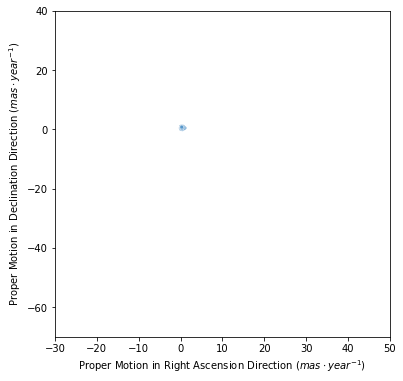

In [8]:
cdalvaro_plot.plot_cluster_proper_motion(cluster_stars,
                                         img_name=f"pm_{cluster.name}",
                                         xlim=(-30, 50),
                                         ylim=(-70, 40))